In [1]:
# !pip install python-igraph
# !pip install matplotlib
# !pip install numpy
# !pip install scipy
# !pip install easygui
# !pip install cairocffi

In [2]:
import pandas as pd
import json
import igraph as ig
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Loading dataset

In [3]:
df = pd.read_csv('HR_edges.csv')

In [4]:
edges = list(df.to_records(index=False))

In [5]:
with open('HR_genres.json', 'r') as f:
    node_data = json.load(f)

In [6]:
node_attrs = [node_data[str(i)] for i in range(len(node_data))]

In [7]:


attributes = pd.DataFrame(node_attrs)

# get all distinct attributes names
genres = pd.DataFrame(columns=['genres'])
styles = []
for i in range(len(attributes.values[:,0])):
    style = attributes.values[i,0]
    if style not in styles:
        genres = pd.concat([genres, pd.DataFrame([style], columns=['genres'])])
        styles.append(style)

genres.head()
print(styles)


['Kids', 'Rap/Hip Hop', 'Pop', 'Jazz', 'International Pop', 'Singer & Songwriter', 'Indie Pop/Folk', 'Films/Games', 'Dance', 'Dancefloor', 'R&B', 'Latin Music', 'Indie Rock', 'Comedy', 'Hard Rock', 'Alternative', 'Reggae', 'Folk', 'Country', 'Metal', 'Rock', 'Film Scores', 'Electro', 'Classical', 'Rock & Roll/Rockabilly', 'Indie Pop', 'Techno/House', 'Jazz Hip Hop', 'Oldschool R&B', 'Brazilian Music', 'Dirty South', 'Bolero', 'Contemporary R&B', 'Asian Music', 'Indie Rock/Rock pop', 'Blues', 'Soul & Funk', 'Spirituality & Religion', 'Dancehall/Ragga', 'TV Soundtracks', 'Soundtracks', 'Tropical', 'Chill Out/Trip-Hop/Lounge', 'Bluegrass', 'Contemporary Soul', 'Opera', 'Instrumental jazz', 'Disco', 'Urban Cowboy', 'Sports', 'Trance', 'Electric Blues', 'Classical Period', 'TV shows & movies', 'Baroque', 'Dubstep', 'Country Blues', 'Nursery Rhymes', 'West Coast', 'Electro Hip Hop', 'African Music', 'Ranchera', 'Indian Music', 'Kids & Family', 'Modern', 'Old school soul', 'Delta Blues', 'Voc

In [8]:
# add edges and nodes to graph
g = ig.Graph(edges=edges, directed=False)
g.add_vertices(len(node_attrs))

In [9]:
for i in range(len(node_attrs)):
    g.vs[i]['ID'] = i

In [10]:
#setting node attributes
for i in range(len(node_attrs)):
    g.vs[i]['music_preferences'] = node_attrs[i]

In [11]:
g.summary()

'IGRAPH U--- 109146 498202 -- \n+ attr: ID (v), music_preferences (v)'

## First analysis

In [12]:
# graph dimensions
print(f"Number of nodes: {g.vcount()}")
print(f"Number of edges: {g.ecount()}")

Number of nodes: 109146
Number of edges: 498202


In [13]:
#extract the first element of the list
print(g.vs['music_preferences'][0][0])

Kids


In [14]:
# Distribution of top 1 genres
list_genres = []
for i in range(len(g.vs['music_preferences'])):
    preference = g.vs['music_preferences'][i]
    if preference is not None:
        list_genres.append(preference[0])

counter = Counter(list_genres)


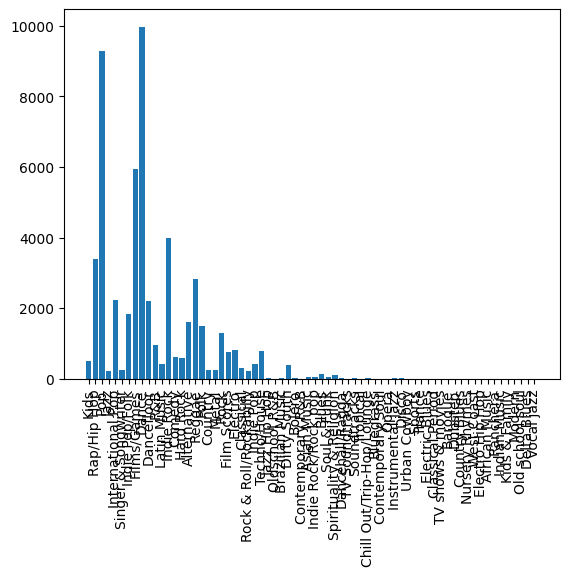

In [15]:
#plot the distribution of top 1 genres
plt.bar(counter.keys(), counter.values())
# increase size of plot
plt.rcParams['figure.figsize'] = [30, 10]
plt.xticks(rotation=90)
plt.show()


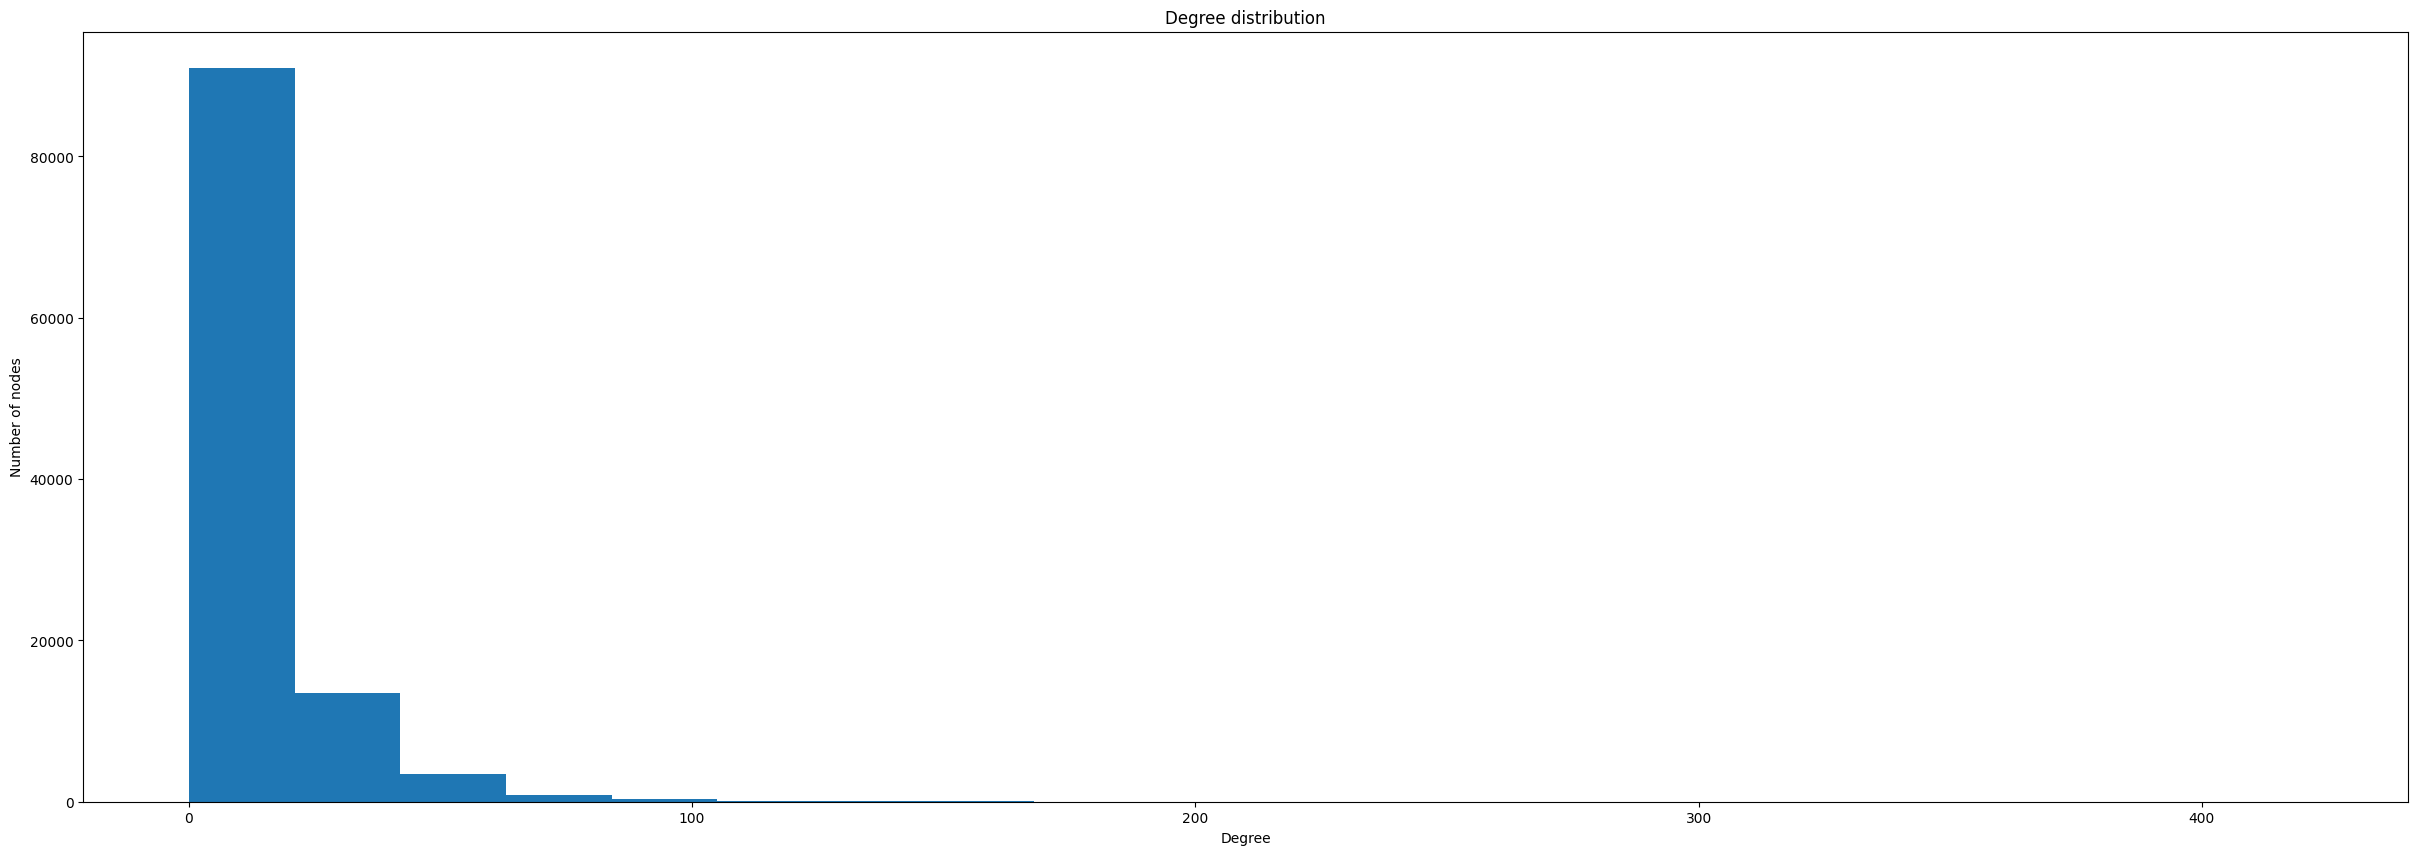

In [16]:
#plot degree distribution
degree = g.degree()
plt.hist(degree, bins=20)
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.title('Degree distribution')    
plt.show()

9.129093141296979


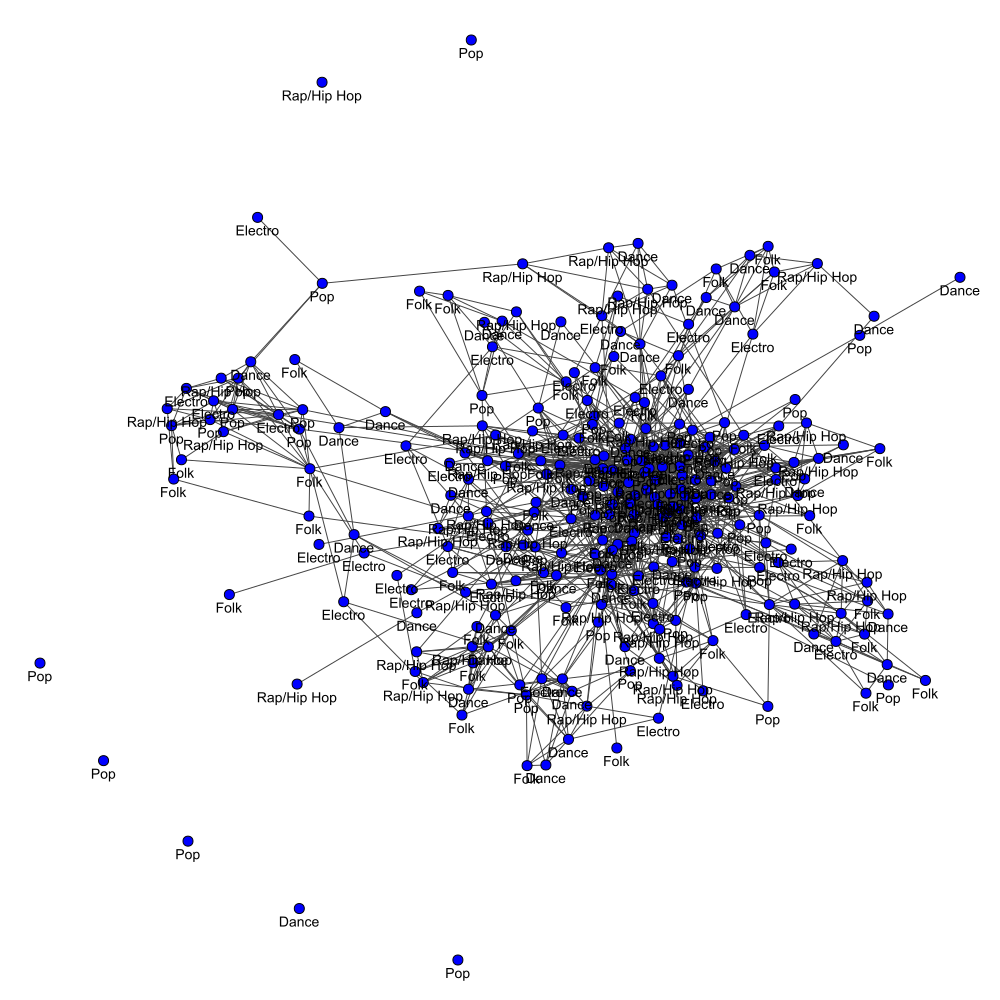

In [17]:
#create a random subgraph
random_subgraph = g.subgraph(np.random.choice(g.vcount(), 100, replace=False))
np_degree = np.array(g.degree())
mean_degree = np.mean(np_degree)
print(mean_degree)
subgraph = g.subgraph([v.index for v in g.vs if v.degree() >= 100])

#plot subgraph
visual_style = {}
visual_style["vertex_size"] = 10
visual_style["vertex_color"] = "blue"
visual_style["edge_width"] = 1
visual_style["layout"] = subgraph.layout("fr")
visual_style["bbox"] = (1000, 1000)
visual_style["vertex_label"] = subgraph.vs["music_preferences"][0]
visual_style["margin"] = 40
visual_style["vertex_label_dist"] = 1.6
visual_style["vertex_label_color"] = "black"
visual_style["edge_curved"] = False
visual_style["edge_arrow_size"] = 0.2
visual_style["edge_arrow_width"] = 0.2

ig.plot(subgraph, **visual_style)

# Genre prediction

In [18]:
#split graph into training and test set
def split_graph(g, p):
    n = g.vcount()
    m = g.ecount()
    edges = g.get_edgelist()
    # shuffle edges
    np.random.shuffle(edges)
    # split edges
    m1 = int(p * m)
    edges1 = edges[:m1]
    edges2 = edges[m1:]
    # create graphs
    g1 = ig.Graph(n=n, edges=edges1, directed=False)
    g2 = ig.Graph(n=n, edges=edges2, directed=False)
    return g1, g2

g_train, g_test = split_graph(g, 0.8)



In [19]:
from collections import Counter
# prediction genres
def genre_prediction(g, node_id):
    neighbors = g.neighbors(node_id)
    genres = []
    for i in range(len(neighbors)):
        genres.append(g.vs['music_preferences'][neighbors[i]][0])
    
    return genres

In [20]:
# subgraph indexs of node with degree >= 100
subgraph_index = [v.index for v in g.vs if v.degree() >= 50]
print("subgraph length: ", len(subgraph_index))
print(type(subgraph_index))
# one hot encoding of node_attrs
df_encoded = pd.DataFrame(columns=styles)

for i in subgraph_index:
    dum = pd.get_dummies(g.vs['music_preferences'][i][0])
    df_encoded = pd.concat([df_encoded, dum], axis=0, ignore_index=True)
df_encoded.fillna(0, inplace=True)
df_encoded.head()


subgraph length:  2821
<class 'list'>


In [ ]:
subgraph = g.subgraph(subgraph_index)
G = subgraph.to_networkx()

In [ ]:
# Perform graph embedding with node2vec
import networkx as nx
from node2vec import Node2Vec
# G = g.to_networkx()
node2vec = Node2Vec(G, dimensions=3, walk_length=20, num_walks=150, workers=4)


Computing transition probabilities:   0%|          | 0/2821 [00:00<?, ?it/s]

In [ ]:

model = node2vec.fit(window=10, min_count=1)


In [ ]:
# Prepare feature matrix and target labels
X = []
y = []
for node in G.nodes():
    embedding = model.wv[node]
    X.append(embedding)
    y.append(df_encoded.loc[node])
y = np.array(y)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
classifier = RandomForestClassifier(n_estimators=5, random_state=42)
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.03716814159292035


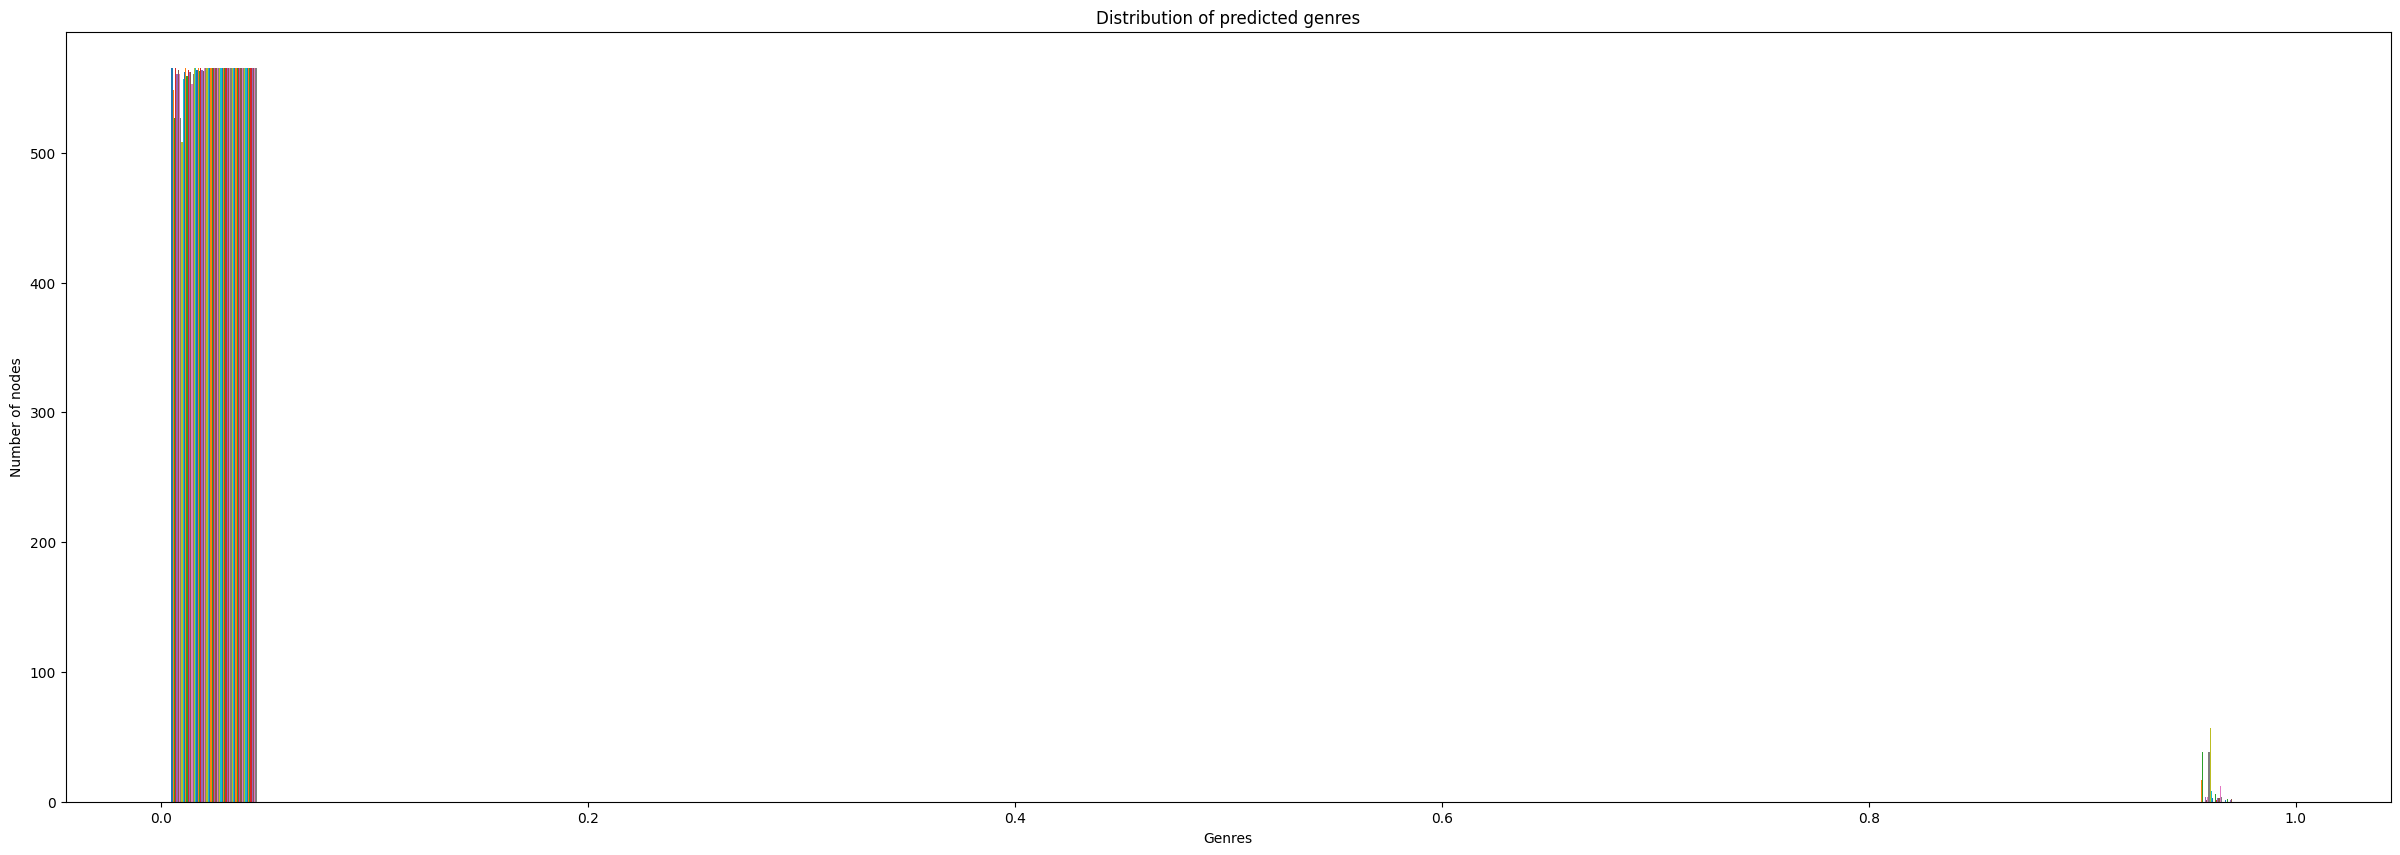

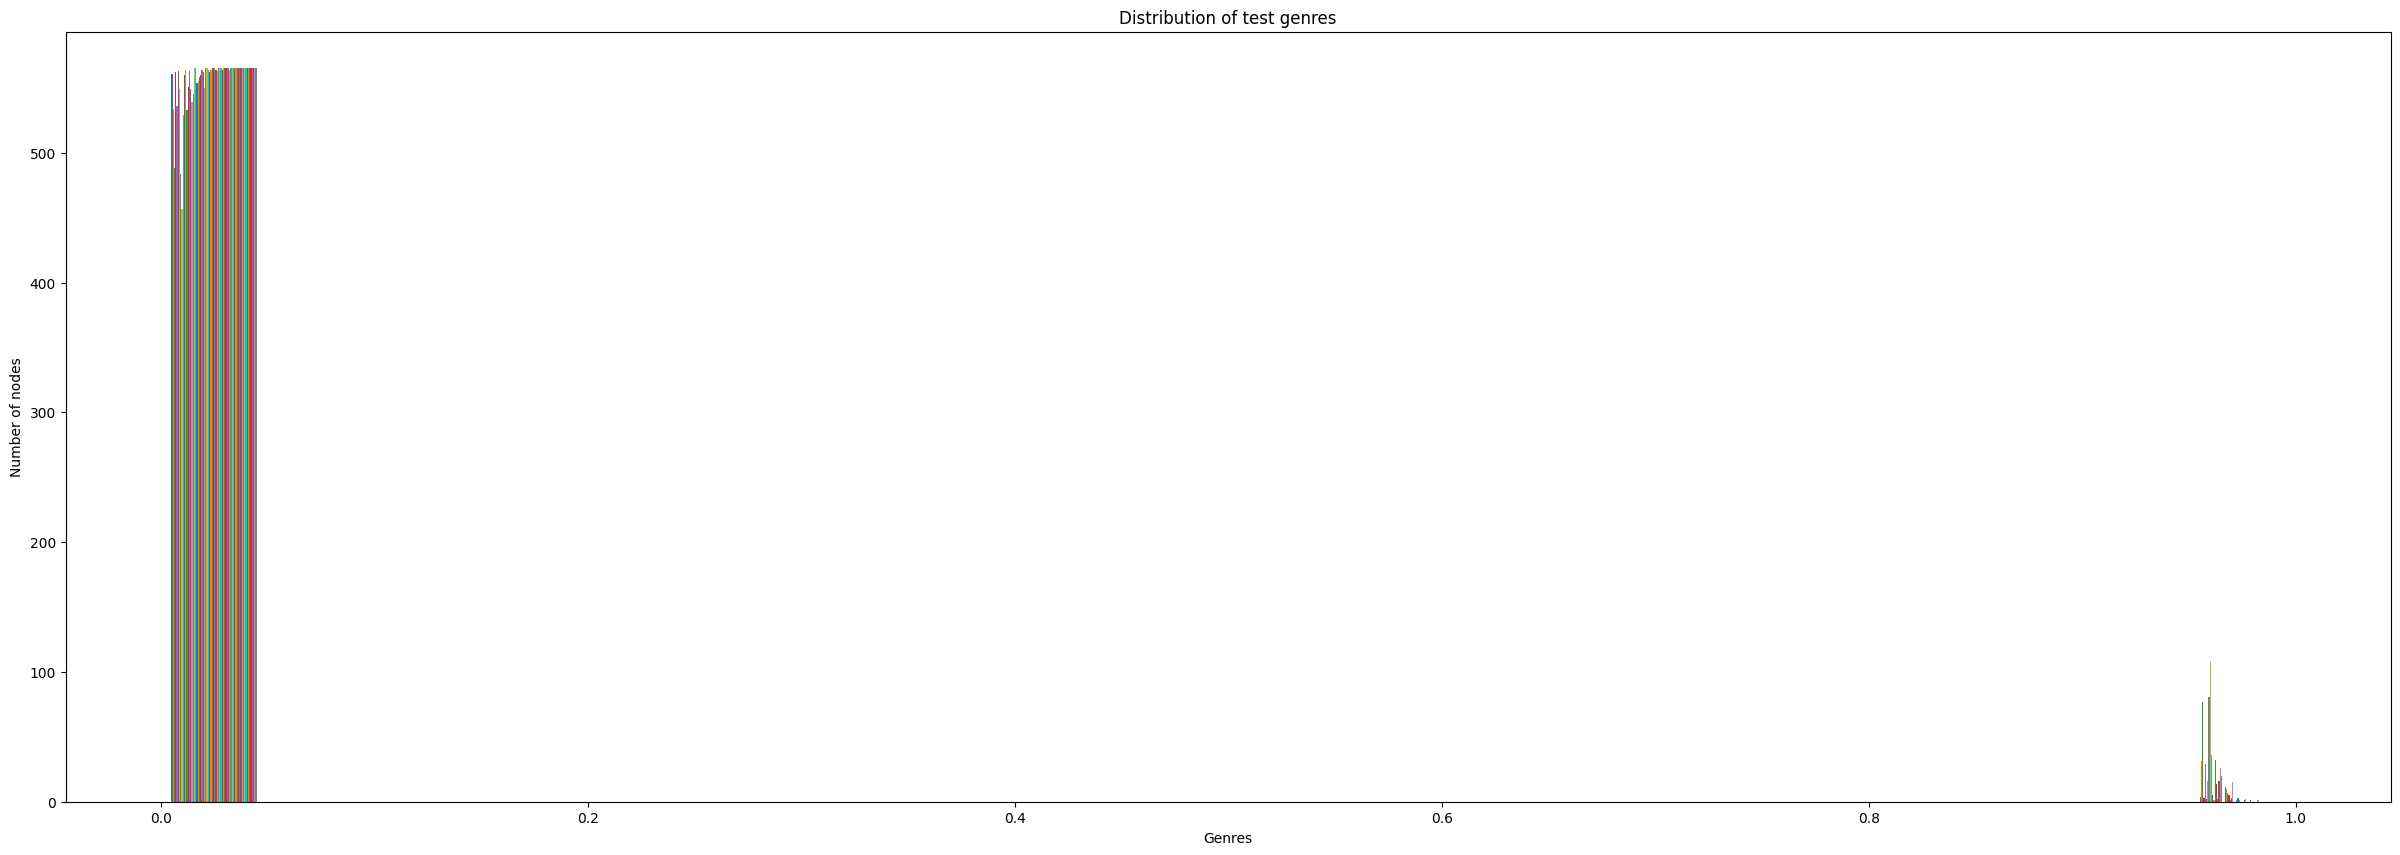

In [ ]:
# plot distribution of y_pred and y_test
plt.hist(y_pred, bins=20)
plt.xlabel('Genres')
plt.ylabel('Number of nodes')
plt.title('Distribution of predicted genres')
plt.show()

plt.hist(y_test, bins=20, linewidth=4)
plt.xlabel('Genres')
plt.ylabel('Number of nodes')
plt.title('Distribution of test genres')
plt.show()


In [ ]:
#plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title, size=15)
plt.show()


ValueError: multilabel-indicator is not supported